In this project let's make a RAG text gen model focused on giving informative, disease responses to cure, such as symptoms of cancer/alzheimers/heart disease/stroke/diabetes/chronic lower respiratory diseases/chronic liver/cirrhosis and COVID

We'll retrieve data relating too:
* Statistical text to harm and also prevention to each of these disease
* Informative molecular data how these diseases form, grow and die
* How patients deal, maintain, get harmed from the disease in there words and also get cured out of them (what treatments that did, what treatments made it worst)
* factual information of the causes of the treatments done in these patients, including statistical ones
* How patients improve, deal or get worst with their nutrition, physical and mental activity
* statstic information, the age group, ethnicity,sex and region do these diseases process
* factual and statistical data on bio genetical these disease move, grow, improve and depreciate
* How labs develop these treatment supplements, bio product, there causes, positive effects and harms
* statistical data on which bio product performs the best of time, how they evolve, proces and die
> **Important**: All manners of patient tied ethnicity and region/ biogenetical data on what they eat and activity (mental and physical) that made the feel worst or get another disease too or helped improve them or even cured there diseases and how there are dealing post curement

The goal of this project is to make a AI chat bot that can give this information, in a specific factual practical way to the query

That includes giving relevant sources of where the retrieved data was grabbed from, but the LLM from summarizes the RAG can implement a response mroe general and easier to understand of the factual data according to the users questions before tied to there needs and specifications asked before, model trying to process around that i they have this it can move other there and more

To be honest this may require a bigger model than 2-3 billion params, to have more generalization and remember response of bigger prompts with more instructions but rather more human response such as a paragraph explaining what the problem (which requires a bigger set of params to tune what it views as it's output to over iterate it's response (this params is also tied to training data) which includes more generalization and precied wider reach of all) that makes it's weights higher making more heavier model with training data, before the tokenization part (the model part is the network and weights and bias), is how can it be fixed with someones capabilties as said before, what they can do to easier process there problem and tieing information on the outside through more to view (this will require a really good open big gen llm  model, not just a only model-it but rather it and also general to view having many training sets to give ouput and understand complex human language, to produce relevant sources according to user like a human advisor (non-beraucratic))

> **NOTE:** I will investigate how to get `chat-gpt API` to use as LLM to be the one reading the complete format prompt at the end, all locally if it doesn't super exceed my local hardwares capabilities. If not than use a better model than gemma-2b-it that is more closer to this and can still fit well in the local hardware using from huggingface

# Let's import all our dependencies

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm
import fitz
from spacy.lang.en import English # Create sentence barrier
from sentence_transformers import SentenceTransformer, util # The embedding model and the metric model to find meaning (similarity search between
# query meaning and the vector data in database from the the sentence chunks we embedded)
# Let's leave the LLM import later so we can know for certain which one we'll use
# Same with BytesAndBytesConfig to know if we need that for LLM, leave it for later, as our hardware isn't able to use flash attention 2
from newspaper import Article
import re

## Let's research and find all relevant data online for our database in RAG

Let's start with `site pages` and `PDF's` from our **data-processing notebook**

In [2]:
# Load CSV file from data processing that has the raw data formatted
df = pd.read_csv("./data-processing/data-processing/whole_sitepages_pdf_text_df.csv")
data_dict = df.to_dict(orient="records")
df = pd.DataFrame(df)
data_dict = df.to_dict(orient="records")

There is a reason we repeated that 2 times. Since for some reason our pdf text seperates lines with `\xa0` even though i replaced that in the `text_formatter` but when you send `df` ito a dataframe it automatically replaces those character for the dictionary when you send it again to `to_dict`

Needs more research to understand why that happens

In [3]:
df.describe().round(2)

,page_char_count,page_word_count,page_sentence_count,page_token_count
count,2770.00,2770.00,2770.00,2770.00
mean,4358.85,684.12,42.36,1089.71
std,3856.78,589.70,67.64,964.20
min,0.00,1.00,1.00,0.00
25%,2232.50,352.00,11.00,558.12
50%,3983.00,601.00,19.00,995.75
75%,5558.75,906.75,37.00,1389.69
max,91872.00,14163.00,1285.00,22968.00


### Let's keep our formatted data into a dictionary that we can manipulate it easier

We got our data on each key, let's add a sentenicer to create sentence barriers

**Let's add SpaCy sentencizer** In our main jupyter notebook now

In [4]:
# Add spacy sentencizer
# Let's do a sample to get how this works
nlp = English()

nlp.add_pipe('sentencizer') # sentencizer is meant to segment the text when nlp("text.") into a object making as sentences
doc = nlp("This is a sentence. This another. The last sentence.")
assert len(list(doc.sents)) == 3 # assert is like an if condition, if this isn't exactly 3 sentences than it would raise an AssertionError
# We want this condition because clearly we have 3 sentences but this is to make sure that sentencizer NLP is working to find sentences
list(doc.sents) # in this list contains each sentences, this efficient for our formatting and dictionary. In a page contains all the sentences to it
# but each sentences is seperated and indentified in our code by a NLP sentencizer
# the doc.sents will simple make the doc object that was done when we sent that sentence string to nlp and it turned it into an object
# really to process it than doc.sents will create barrier on only that doc object format that sentencizer understands

[This is a sentence., This another., The last sentence.]

### The sentencizer is working, let's make a function

Let's function both this sentencizer with the accuracte amount of total sentences and
make the chunks of 10 sentences in 1 function.

> Also let's allow only sentences containing more than 30 tokens, anything less will excluded

We are removing the less 30 tokens on the chunks because this is were we will process it into the embedding. If we minimized on sentences it wouldn't be clear to the total sentences as text creating is not fully fixed  (some sentences bigger than other) but in total 10 sentences should contain an expected amount of characters in total. In our case really doing it on the chunking process just makes it more practical as that's the area that will finally be embedded. So we make sure after embedding that each chunk contains more than 30 tokens.

Plus the NLP on sentencizer well sentencize even when it sees `1.` or `3.` since it ends in a period and has a space. That's why it's better after nlp and chunking to only allow > 30 size tokens on each batch

#### Let's see if our nlp sentencizing works as it should for all of them, than afterwords we can proceed to place them in a dict --> chunks

In [5]:
# function

def sentencizer_and_chunking(data_dict: list,
                             num_sents_per_chunk: int=10):
    """
    Sentencize your sentences, add them to dictionary with accurate total sentences,
    chunk each sentences into 10 per group, add to dict again with right labels,
    than exclude any chunks with less than 30 tokens.
    """

    # Let's make a list to contain all the seperated sentences for a sample
    # Make sure all text here is string when it identifies it, for some reason the nlp when seeing numbers can detect floats or ints even if they were
    # in dataframe into dict so convert tem here to str to be sure
    nlp = English()
    nlp.add_pipe('sentencizer')
    for i in data_dict:
        text = str(i['text'])
        doc = nlp(text)
        sentence = [str(sent) for sent in doc.sents]
        i['sentence'] = sentence
        i["page_sentence_count_spacy"] = len(i['sentence'])

        # Chunk sentences
        # Split the list
        # for each item in rane of 0 to the max length of items in sentence_list, iterate by a step of num_sents_per_chunk, than have it return
        # the sentence position that has 10
        sentence_list = i['sentence']
        split_sentence_list = [sentence_list[i:i + num_sents_per_chunk] for i in range(0, len(sentence_list), num_sents_per_chunk)]
        # Loop through the pages and split the sentences into chunks
        i["sentence_chunk"] = [chunk for chunk in split_sentence_list]
        i['num_chunks'] = len(i["sentence_chunk"])

    return data_dict

def chunks_and_tokenize(data_dict: list,
                        token_amount: int):
    """
    This will make a chunk_list filled of dictionaries, to make analyzes more practical.
    It will exclude a token amount to allow only a set minimum # tokens in our chunks
    """

    # Make chunk list(dict)
    pages_and_chunks = []
    for i in data_dict:
        for sentence_chunk in i['sentence_chunk']:
            chunk_dict = {}
            chunk_dict["link_or_page_number"] = i["link_or_page_number"]
            # Join sentences together as a paragpraph structure (as a chunk so it's just a single string than rather seperated in the sentence chunk all
            # together)
            joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
            joined_sentence_chunk = re.sub(r'\.([A-Z0-9])', r'. \1', joined_sentence_chunk) # For any full stopped characters
            chunk_dict["sentence_chunk"] = joined_sentence_chunk

            # Get stats for chunk dict
            chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
            chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")]) # Now it's seperated in the entire dictionary, that 
            # way calling each item is really each character before a space making it a word

            # Let's only allow 30 tokens or above
            chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4
            pages_and_chunks.append(chunk_dict)

    # Let's only allow 30 tokens above for each chunk
    df = pd.DataFrame(pages_and_chunks)
    pages_and_chunks_overmin_token_dict = df[df["chunk_token_count"] > token_amount].to_dict(orient="records")
    
    return pages_and_chunks, pages_and_chunks_overmin_token_dict

It will count 20 even if there was 15 sentences since it rounds

in this line of code: `sentence = [str(sent) for sent in doc.sents]` the doc.sents is to make the object nlp in sents barrier, once it does than each sentence inside that object will be make into string type and sentence is now the variable containing just the sentence for the page or link we're looking at

#### We can analyze after sentencizing and chunking, too see if everything was good

By seeing in dataframes but all of this after making sentences than chunks

In [6]:
sentences_and_chunks = sentencizer_and_chunking(data_dict=data_dict,
                                                num_sents_per_chunk=10)

In [7]:
chunk_token_dict, chunk_min_token = chunks_and_tokenize(data_dict=data_dict,
                                                        token_amount=30)

Let's analyze these chunks now

In [8]:
len(chunk_token_dict), len(chunk_min_token)

(11934, 11669)

#### Get the funtion grab the seperated sentences and add them to `data_dict` we're all those other keys are and get an accurate sentence count

or you can add them to the dataframe `df` if that is more practical, as another column filled with that sentence content, make it drop the last sentences with new ones. This is so that we can actually chunk our sentences by 10 since it's unpredictable to do this without seperating them with NLP

In [9]:
pages_sentences_and_chunks_df = pd.DataFrame(sentences_and_chunks)
# pages_and_sentences_df.head()
pages_sentences_and_chunks_df.describe().round(2)

,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_chunks
count,2770.00,2770.00,2770.00,2770.00,2770.00,2770.00
mean,4358.85,684.12,42.36,1089.71,38.33,4.31
std,3856.78,589.70,67.64,964.20,53.40,5.33
min,0.00,1.00,1.00,0.00,1.00,1.00
25%,2232.50,352.00,11.00,558.12,11.00,2.00
50%,3983.00,601.00,19.00,995.75,19.00,2.00
75%,5558.75,906.75,37.00,1389.69,37.00,4.00
max,91872.00,14163.00,1285.00,22968.00,1170.00,117.00


In [13]:
# pages_sentences_and_chunks_df[:2]
data_dict[2]['num_chunks']

2

In [14]:
data_dict[2]['page_sentence_count_spacy']

15

### Now let's make a seperate dictionary in the function called `chunk_dict`

showing relevant information for our daata analysis (we can in future add each step process in other variables in a OOP) after that than we can any chunk that has less than 30 tokens

### This chunking is correctly because it needs to find each chunk per page

The total chunks can be really big

In [11]:
# chunk_token_dict[:2]

In [16]:
# data_dict[:5]

In [17]:
df = pd.DataFrame(chunk_token_dict)
df.describe().round(2)

,chunk_char_count,chunk_word_count,chunk_token_count
count,11934.00,11934.00,11934.00
mean,1007.98,155.80,252.00
std,873.15,144.56,218.29
min,1.00,1.00,0.25
25%,486.00,71.00,121.50
50%,683.00,103.00,170.75
75%,1317.00,202.75,329.25
max,14241.00,2630.00,3560.25


### Our chunks have a low token count

Let's add a minimum amount to keep a worthy quantity of tokens

In [18]:
# for row in df[df["chunk_token_count"] <= 30].sample(10).iterrows():
#     print(f'Page Number or link: {row[1]["link_or_page_number"]} | Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

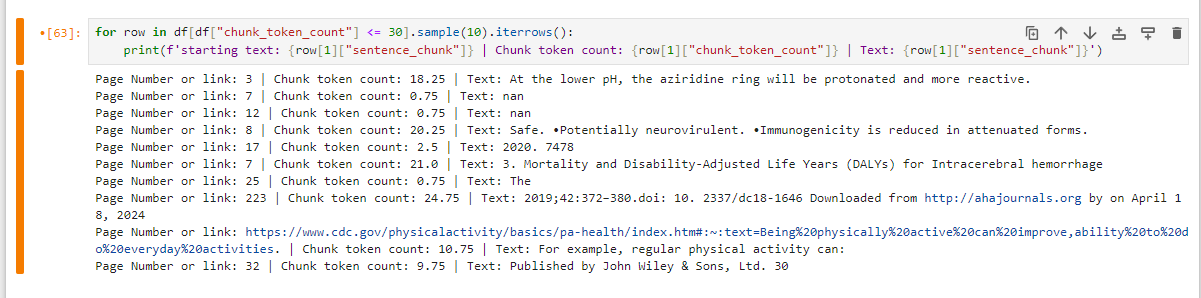

### These tokens are not reliably, they give either titles, captions or headers

Let's change to only allow above 30 tokens

Let's place this inside our function

In [19]:
# chunk_min_token[:10]

### Great! Let's now finally embed our sentences into numeric form

using `all-mpnet-base-v2` is seen as the best in sbert.net

It has low memory size, A high embedding speed and semantic search. It's now the complete fastest in embed but all around it's better than the rest because there is another that has 1 digit above in speed for embedding but it takes long to cross semantic search and has a bigger size storage requirement which isn't worth it

So we'll stick to `all-mpnet-base-v2`

#### Let's create a function to just embed our data

We keep this step seperate if we needed to manipulate anything additionally in the future with just our function for the NLP and chunking process

In [20]:
# Let's use the sentence_transformers for the embedding
embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2',
                                      device='cuda')

In [23]:
def embedding_data(chunk_data: list,
                   batch_size: int=10,
                   convert_to_tensors: bool=True):
    """
    Embeds the whole sentence_chunks inside the dictionary into
    vectors.
    """
    
    for i in chunk_data:
        i["embeddings"] = embedding_model.encode(i["sentence_chunk"])

    df = pd.DataFrame(chunk_data)
    df.to_csv("./chunks_tokenized.csv", index=False)
    # Let's batch them into 32 to make the processing faster
    # text_chunks = [i['sentence_chunk'] for i in chunk_min_token]

    # text_chunk_embeddings = embedding_model.encode(text_chunks,
    #                                                batch_size=batch_size,
    #                                                convert_to_tensor=True)
    return chunk_data

#### I tried the batching but it made no difference with no batching

So it's simplier to comment out the code doing that

In [24]:
text_chunk_embeddings = embedding_data(chunk_min_token)

Great we just added the embeddings to our dictionary on `chunk_min_token`

We can actually batch them to make the process faster

### Lets add the `text_chunk_embedding` inside our `chunk_min_token` dict

✅than after we will save it to a csv to save our embedded format vector data in the database

## Let's now load our csv embeddings (tokens officially) into a dataframe

In [2]:
# loaded chunks and tokens
df_embeds = pd.read_csv('./chunks_tokenized.csv')
df_embeds[:3]

,link_or_page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embeddings
0,0,1. Checkpoints Inhibitors: Checkpoint inhibito...,878,128,219.5,[ 7.50207156e-02 -6.30471781e-02 -2.76404526e-...
1,0,"Some drugs, known as apoptosis inducers, can t...",830,127,207.5,[ 2.01551374e-02 -1.88169186e-03 -3.07534169e-...
2,0,Senescence inducers target speciﬁc pathways in...,398,59,99.5,[ 4.52404656e-02 1.68271977e-02 -5.62751805e-...


## We have to convert the embeddings column in df into `tensors`

First we have grab each element in embeddings row and make into a numpy array first before making them into tensors

In [3]:
# convert to np array on embeddings

# Apply to each element in row (rows content) is what the apply(lamda) is doing. np already makes into array when you say it came from np.fromstring
# fromstring into np array
df_embeds["embeddings"] = df_embeds["embeddings"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# convert df into list[dict]
embeds_dict = df_embeds.to_dict(orient="records")

# convert into tensors
embeddings = torch.tensor(np.array(df_embeds["embeddings"].to_list()), dtype=torch.float32).to('cuda')

In [4]:
embeddings.shape

torch.Size([11669, 768])

This is standard dimension for the sentence transformer we got

We also placed this embeddings into a `list` so we can use it later when it comes to processing the whole rag pipeline

## Let's use the whole RAG this time to see if everything is working as expected

In [5]:
from time import perf_counter as timer

In [6]:
# # RAG
# query = "what treatments can be done when someone has breast cancer"

# # embed query
# query_embeddings = embedding_model.encode(query,
#                                           convert_to_tensor=True).to('cuda')

# # compare query embeddings with data embeddings using dot score
# start_time = timer()
# dot_scores = util.dot_score(a=query_embeddings, b=embeddings)[0]
# end_time = timer()

# # Get top5 scores
# scores, indices = torch.topk(dot_scores, k=5)

# print(f"Scores: {scores}")
# print(f"Indices: {indices}")

In [40]:
chunk_min_token[301]

{'link_or_page_number': '13',
 'sentence_chunk': 'Patients undergoing mastectomy may also need radiation if the tumor is large or there is lymph node involvement. Women undergoing mastectomy who elect breast reconstruction have several options, including the type of tissue or implant used to restore breast shape. Reconstruction may be performed at the time of mastectomy or later, but often requires more than one surgery. Depending on cancer stage, subtype, and sometimes other test results, such as tumor gene expression profiling (e.g., Oncotype DX), treatment may also involve chemotherapy (before and/or after surgery), hormone (anti-estrogen) therapy, targeted therapy, and/ or immunotherapy (e.g., immune checkpoint inhibitors). Survival: The 5- and 10-year relative survival rates are 91% and 85%, respectively, for invasive breast cancer overall, mostly because two-thirds of women are diagnosed with localized-stage disease. Despite progress over time, the 5-year survival rate is 10% low

### Let's make the visualization of the output more appealing by applying functions

In [6]:
import textwrap

In [7]:
# Make a text wrapper

def text_wrapper(text):
    """
    Wraps the text that will pass here
    """

    clean_text = textwrap.fill(text, 80)

    print(clean_text)

### Let's make a function for the whole rag output

In [8]:
# Let's first get the embedding model
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device='cuda')

In [9]:
# functionize

def rag_pipeline(query,
                 embedding_model,
                 embeddings,
                 device: str,
                 chunk_min_token: list):
    """
    Grabs a query and retrieve data all in passages, augments them, than it
    it outputs the top 5 relevant results regarding query's meaning using dot scores.
    """

    # Retrieval
    query_embeddings = embedding_model.encode(query, convert_to_tensor=True).to(device)

    # Augmentation
    dot_scores = util.dot_score(a=query_embeddings, b=embeddings)[0]

    # Output
    scores, indices = torch.topk(dot_scores, k=5)
    counting = 0
    for score, idx in zip(scores, indices):
        counting+=1
        clean_score = score.item()*100
        print(f"For the ({counting}) result has a score: {round(clean_score, 2)}%")
        print(f"On index: {idx}")
        print(f"Relevant Text:\n")
        print(f"{text_wrapper(chunk_min_token[idx]['sentence_chunk'])}\n")

To view the score rounded we can't see it as a tensor but rather python float which as simple as saying `score.item()`

In [12]:
query = "How does a stroke happen?"
rag_pipeline(query=query,
             embedding_model=embedding_model,
             embeddings=embeddings,
             device="cuda",
             chunk_min_token=embeds_dict)

For the (1) result has a score: 73.35%
On index: 11458
Relevant Text:

The only option is to watch, wait and hope. Nonetheless, the locality of a
stroke can determine just how and what area of a person’s functioning may be
affected. For example, brain stem strokes are the most catastrophic as they can
affect involuntary functions such as breathing and heart rate. Cerebellum
strokes affect balance and coordination, while strokes restricted to the right
or left hemisphere of the brain can cause paralysis on opposing sides of the
body. What causes a stroke? There are two major causes of stroke. The majority
of strokes result from reduced blood flow to the brain due to a blocked or
narrowed blood vessel, with the remainder resulting from a burst blood vessel or
brain bleed. Blocked artery – ischemic stroke Stroke resulting from an
obstruction or constriction in the blood vessels that supply oxygen to the brain
is known as ischemic stroke. In ischemic stroke, blood supply can be restricted


#### Great! We have made the RAG Pipeline

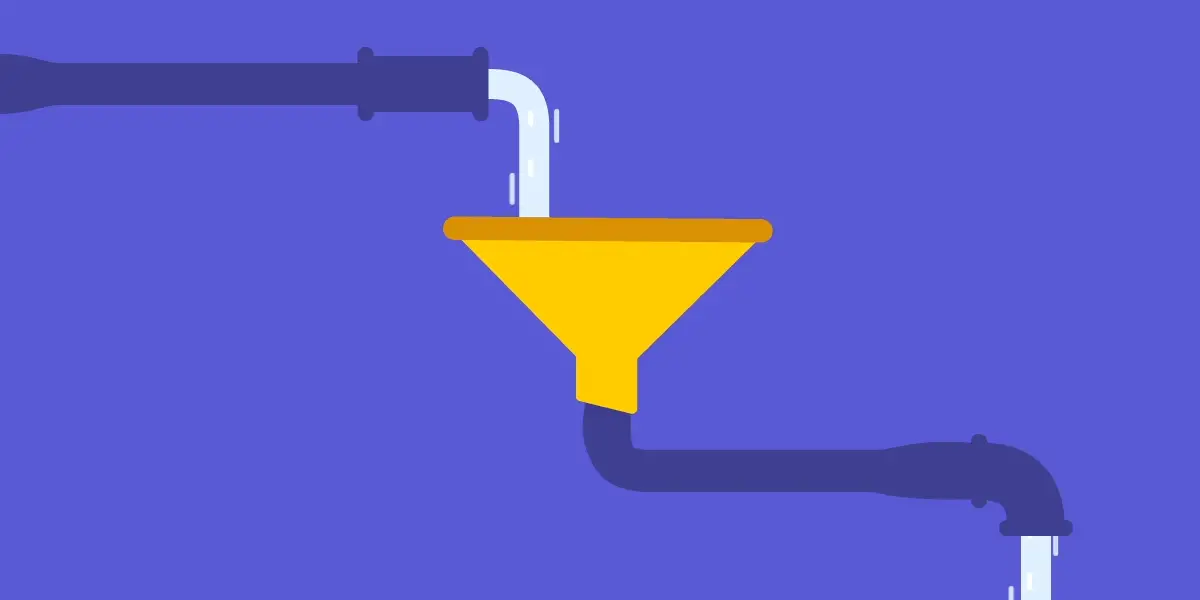

# Now let's decide what LLM we'll use

In this project, I don't want to reuse gemma-2b-it because it's not that general and lacks general more modern language model

> Make the output more as a paragraph response of a key view points of facts and suggestions mixed for the users own needs or wants
>

### We're going to use chatgpt API to load it

Here are the docs - https://platform.openai.com/docs/guides/text-generation

According to OpenAI
* We need to make a request containghte inputs and our API key
* For the response of our request will contain the models output
* `gpt-3.5-turbo` can be accessed through the chat completions API endpoint

In [10]:
# !pip install openai

In [11]:
# import OpenAI class for gpt3.5 turbo
from openai import OpenAI

In [12]:
import json

Let's make a sample first to see how this API LLM works

Apparently the LLM responds on json, we'll have to give json dumps

We're using an exercise from here: https://cookbook.openai.com/examples/how_to_format_inputs_to_chatgpt_models

In [13]:
# # Let's make a sample
# # You need to pass API Keys into () on OpenAI

# client = OpenAI(api_key=OPEN_AI_API_KEYS)
# gpt_model = "gpt-3.5-turbo"
# # We need to pass it authentication headers using bearer auth to get access to the model
# response = client.chat.completions.create(
#     model=gpt_model,
#     messages=[
#         {"role": "system", "content": "You are a helpful assistant."},
#         {"role": "user", "content": "Knock Knock."},
#         {"role": "assistant", "content": "Who's there?"},
#         {"role": "user", "content": "Orange."},
#     ],
#     temperature=0,
# )

In [97]:
# url = "https://api.openai.com/v1/chat/completions"
# headers = {
#     "Content-Type": "application/json",
#      "Authorization": f"Bearer {OPEN_AI_API_KEYS}"
# }

### Let's view the models response on `json` format

In [104]:
print(json.dumps(json.loads(response.model_dump_json()), indent=4))

{
    "id": "chatcmpl-9HrH2MyJPDiA79y173hDibckvmGJX",
    "choices": [
        {
            "finish_reason": "stop",
            "index": 0,
            "logprobs": null,
            "message": {
                "content": "Orange who?",
                "role": "assistant",
                "function_call": null,
                "tool_calls": null
            }
        }
    ],
    "created": 1714043388,
    "model": "gpt-3.5-turbo-0125",
    "object": "chat.completion",
    "system_fingerprint": "fp_c2295e73ad",
    "usage": {
        "completion_tokens": 3,
        "prompt_tokens": 35,
        "total_tokens": 38
    }
}


## The API process shows..

This:
* The model for `GPT-3.5-turbo` process tokens differently from the tokenizers used before. It processes tokenization in different ways depending the type of characters placed on the input. The more complex meaning the word has the more subwords extracts and narrowness it needs to have to split characters to find the most similiar appropiate meaning to that input meaning. The less complex will require less tokenization to process as it's more common it's training parameters that it saw on it's training data such as hello, goodnight or breakfast etc. words used everyday compared to scientific, ancient, complex jokes words or even riddles.
* The `completion_tokens` means the amount of tokens it made to give an output which was 3, the `prompt_tokens` is the amount of tokens it needed to make for the input prompt which is a little more than expected but still for very cheap for usage. In reality as of April 2024, OpenAI charge $0.0005 for every 1,000 tokens made. We have made 38 tokens (`total_tokens`) with input + output combined. In general we can make several responses until it will charge us 50% of 0.1 cent 🆒 SO CHEAP!!

**Let's view the response by itself**

In [105]:
response.choices[0].message.content

'Orange who?'

### Let's view another example to understand it more

In [14]:
client = OpenAI(api_key=api_key)
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Explain asynchronous programming in the style of willy wonka."},
    ],
    temperature=0,
)

# print(response.choices[0])

In [15]:
json_form_response = json.dumps(json.loads(response.model_dump_json()), indent=4)  #.replace("\n", '').strip()
print(json_form_response)

{
    "id": "chatcmpl-9J0JQBgSNurjwI9B5krlsVaX1VGDT",
    "choices": [
        {
            "finish_reason": "stop",
            "index": 0,
            "logprobs": null,
            "message": {
                "content": "Ah, dear friend, let me take you on a whimsical journey into the world of asynchronous programming, where time dances to its own tune just like the Oompa Loompas in my chocolate factory!\n\nPicture this: in the land of synchronous programming, tasks are like obedient little children, waiting in line for their turn to be completed. But in the magical realm of asynchronous programming, tasks are like mischievous squirrels, darting about freely and completing their work in their own time.\n\nJust as my chocolate river flows endlessly, in asynchronous programming, multiple tasks can run simultaneously without waiting for each other. It's like having a grand feast where each dish is prepared by a different chef, all working in harmony to create a delightful meal.\n\nSo,

### OK we have view how to place inputs and get outputs with chat-gpt

IT's very simple, that it doens't require manually tokenizing and bringing back to numbers and than text

All of that is already done in 1 go!

> Let's try to functionize than any time we make model request so we don't have to overlap our api request whenever there is an adjustment on code other than the response. It's best to keep that in 1 cell and in a function to need rewrite code

In [13]:
import os
api_key = os.getenv('OPEN_AI_API_KEY')

Let's engineer first how we'll functionize just the request

already automizing the input and getting output cleanly informative format

let's focus on making this functional, than we can add more improvative features such as prompt generation and rag

#### Let's make a function containing the message for the request

In [14]:
# message to model
def message_request_to_model(input_text: str):
    """
    Message to pass to the request on API
    """
    message_to_model = [
        {"role": "system", "content": "You are a helpful assistant called 'Stellar'."},
        {"role": "user", "content": input_text}, # This must be in string format or else the request won't be successful
    ]

    return message_to_model

#### Create a function containing the output of response on request

In [15]:
# Functionize API request from the very beginning as calling gpt for the first time
def request_gpt_model(input_text,
                      temperature,
                      message_to_model_api,
                      model: str="gpt-3.5-turbo"):
    """
    This will pass in a request to the gpt api with the messages and
    will take the whole prompt generated as input as intructions to model
    and output the similiar meaning on the output.
    """
    # Create client
    client = OpenAI(api_key=api_key)

    # Make a request, for the input prompt
    response = client.chat.completions.create(
        model=model,
        messages=message_to_model_api,
        temperature=temperature,
    )

    # Output the message in readable format
    output = response.choices[0].message.content
    json_response = json.dumps(json.loads(response.model_dump_json()), indent=4)
    # print(f"{text_wrapper(output)}")
    print(output)
    return output, json_response

In [93]:
# query = "How does a stroke happen?"
# request_gpt_model(input_text=query,
#                   temperature=0)

We have used so far 731 tokens.

This is high but it's because of the output text the model is giving. there usually complex and contructed language text the model has to use in the transformer meaning search but also from the big paragraphs it ouputs from a simple small input text.

This is good though as it shows the completeness of the models ability to be thorough on all things to explain complete but yet practical enough to explain it simply without so much detail or facts. Just rather to the point of what question was asked and explaine ach point to there full exact point and push more.

### Awesome! The request function is working

Now that this is working let's work on tweaking and customizing it with more prompt enginerring 

Let's still not place the rag yet, we'll do that last. Let's make sure everything is working fine before the final phase we want to keep the code consistent and clean

> Let's begin first by adding a sample prompt enginerring we'll add in the input.. We'll try (1) assistant role and (2) on user role. To see which would the model best respond towards.
>
By the sample format on the roles i mean adding the prompt instructions to the model, to give us the the best formatted and type of response based on the context we want such as context item but **NOT** from *RAG* yet, just from a sample of instruction text we'll give it with a few examples.

Just as we learned from the original RAG project

# The LLM is working as expected now let's fully implement rag with LLM together

All into 1 function

### Save a log report of the models activity during request

In [16]:
# Functionize saving output to file
def save_log_models_activity(query, prompt, continue_question, output, cont_output, embeds_dict, json_response,
                             model, rag_pipeline, message_request_to_model, indices, embedding_model, source_directed: str):
    """
    This will save the models input and output interaction, onto
    a txt file, for each request, labeling model that was used.
    What sort of embedding process, pipeline that was used and
    date and time it was ran
    """
    # If there is a follow up question:
    input_query = ""
    if continue_question != "":
        input_query += continue_question
    else:
        input_query += query
    
    clean_query = re.sub(r'[^\w\s]', '', input_query).replace(' ', '_')
    file_path = os.path.join("./logfiles/april-2024/", f"{clean_query}.txt")
    
    #Open the file in write mode
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(f"Original Query: {query}\n\n")
        if prompt != "":
            file.write(f"Base Prompt: {prompt}\n\n")
        if continue_question != "":
            file.write(f"Follow up question:\n\n{continue_question}\n\n")
            file.write(f"Output:\n\n {cont_output}")
        else:
            file.write(f"Output:\n\n{output}\n\n")

        # Json response
        file.write(f"\n\nJson format response: {json_response}\n\n")
    
        for idx in indices:
            # Let's log the models activity in txt file
            if rag_pipeline:
                file.write(f"{source_directed}")
                file.write(f"\n\nPipeline Used: RAG\n")
                file.write(f"Embedding Model used on tokenizing pipeline:\n\n{embedding_model}\n")
                
            file.write(f"\nRelevant Passages: {embeds_dict[idx]['sentence_chunk']}\n\n")
            break
        file.write(f"Model used: {model}\n")
        # file.write(f"{message_request_to_model}")
        today = date.today()
        current_time = datetime.now().time()
        file.write(f"Date: {today.strftime('%B %d, %Y')}\nTime: {current_time.strftime('%H:%M:%S')}\n\n")

In [18]:
from typing import Dict, Any, List

#### Retrieves RAGS output scores and indices

In [19]:
# Function
def rag_resources(query: str,
                  device: str="cuda"):
    """
    Extracts only the scores and indices of the top 5 best results
    according to dot scores on query.
    """

    # Retrieval
    query_embeddings = embedding_model.encode(query, convert_to_tensor=True).to(device)

    # Augmentation
    dot_scores = util.dot_score(a=query_embeddings, b=embeddings)[0]

    # Output
    scores, indices = torch.topk(dot_scores, k=5)

    return scores, indices

# Format the prompt
def prompt_formatter(prompt: str,
                     context_items: List[Dict[str, Any]]):
    """
    Format the base prompt with the user query.
    """

    context = "- " + "\n- ".join(i["sentence_chunk"] for i in context_items)

    base_prompt = """In this text, you will act as supportive medical assistant.
Give yourself room to think.
Explain each topic with facts and also suggestions based on the users needs.
Keep your answers thorough but practical.
You as the assistant will recieve context items for retrieving information.
Use the following examples as reference for the ideal answer style.
\nExample 1. 
Query: How does genetics effect cancer?
Answer: Some people inherit gene mutations (changes) from their parents. These inherited mutations are though rare but can occur in BRCA1 and BRCA2 gene mutations, which are related to break or ovarian cancer.
\nExample 2.
Query: Can you get heart disease if you had a stroke?
Answer: Yes, you can get heart disease. Chances get higher if you are viewing increase in blood pressure, diabites, cholesterol or smoking. Strokes however don't directly cause heart disease but does lead to it if no treatment is done.
\nExample 3.
Query: What type of treatment should you do if you get breast cancer?
Answer: That may vary depending on the size of the cancer? If you got a response from your doctor I can help suggest you what considerations you can do. One of the main treatments you can do is getting a surgey, chemotherapy or hormonal therapy. If you give me more details on your doctors response, I can help narrow what treatment can work best according to your record and body. 
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: Please extract the context items that helped you answer the user's question
<extract relevant passages from the context here>
User query: {query}
Answer:"""

    prompt = base_prompt.format(context=context, query=prompt)

    return prompt

In [20]:
from datetime import datetime, date

#### Create entire system to call rag, use the outputs as prompts for LLM

In [21]:
# Function RAG-GPT
def rag_gpt(query: str,
            continue_question: str="",
            rag_pipeline: bool=True,
            temperature: int=0,
            model: str="gpt-3.5-turbo",
            embeds_dict=embeds_dict):
    """
    This contains the RAG system implemented with
    OpenAI models. This will process the the data through
    RAG, afterwards be formatted into instructive prompt to model
    filled with examples, context items and query. Afterwards,
    this prompt is passed the models endpoint on API and cleanly return's
    the output on response.
    """

    if continue_question == "":
        print(f"Your question: {query}\n")
    else:
        print(f"Your Question: {continue_question}\n")
        
    # RAG resources
    # scores, indices = rag_resources(query)
    if rag_pipeline:
        scores, indices = rag_resources(query)
        # Get context item for prompt generation
        context_items = [embeds_dict[idx] for idx in indices]
    
        # augment the context items with the base prompt and user query
        prompt = prompt_formatter(query, context_items)

        # Show analytics on response data   
        top_score = [score.item() for score in scores]
        print(f"Highest Result: {round(top_score[0], 2)*100}%\n")

    else:
        prompt = query

    # LLM input prompt
    
    # If there is follow up question
    # Let's log the models activity in txt file    
    if continue_question != "":
        message_request = message_request_to_model(input_text=continue_question)
        cont_output, json_response = request_gpt_model(continue_question, temperature=temperature, message_to_model_api=message_request, model=model)
        cont_output
        output = ""
        index = embeds_dict[indices[0]]
        # Let's get the link or page number of retrieval
        link_or_pagnum = index["link_or_page_number"]
        link_or_pagnum = str(link_or_pagnum)
        if link_or_pagnum.isdigit():
            # link_or_pagnum = int(link_or_pagnum)
            source = f"The sources origins comes from a PDF"
            save_log_models_activity(query=query,
                                     prompt=prompt,
                                     continue_question=continue_question,
                                     output=output,
                                     cont_output=cont_output,
                                     embeds_dict=embeds_dict,
                                     json_response=json_response,
                                     model=model,
                                     rag_pipeline=rag_pipeline,
                                     message_request_to_model=continue_question,
                                     indices=indices,
                                     embedding_model=embedding_model,
                                     source_directed=source)

        else:
            link = f"Source Directed : {index['link_or_page_number']}"
            save_log_models_activity(query=query,
                                     prompt=prompt,
                                     continue_question=continue_question,
                                     output=output,
                                     cont_output=cont_output,
                                     embeds_dict=embeds_dict,
                                     json_response=json_response,
                                     model=model,
                                     rag_pipeline=rag_pipeline,
                                     message_request_to_model=continue_question,
                                     indices=indices,
                                     embedding_model=embedding_model,
                                     source_directed=link)
    
    # If no follow up question
    else:
        message_request = message_request_to_model(input_text=prompt)
        output, json_response = request_gpt_model(prompt, temperature=temperature, message_to_model_api=message_request, model=model)
        output
        cont_output = ""
        if rag_pipeline:
            index = embeds_dict[indices[0]]
            # Let's get the link or page number of retrieval
            link_or_pagnum = index["link_or_page_number"]
            link_or_pagnum = str(link_or_pagnum)
            if link_or_pagnum.isdigit():
                print("is digit\n")
                source = f"The sources origins comes from a PDF"
                save_log_models_activity(query=query,
                                         prompt=prompt,
                                         continue_question=continue_question,
                                         output=output,
                                         cont_output=cont_output,
                                         embeds_dict=embeds_dict,
                                         json_response=json_response,
                                         model=model,
                                         rag_pipeline=rag_pipeline,
                                         message_request_to_model=query,
                                         indices=indices,
                                         embedding_model=embedding_model,
                                         source_directed=source)
    
            else:
                link = f"Source Directed : {index['link_or_page_number']}"
                save_log_models_activity(query=query,
                             prompt=prompt,
                             continue_question=continue_question,
                             output=output,
                             cont_output=cont_output,
                             embeds_dict=embeds_dict,
                             json_response=json_response,
                             model=model,
                             rag_pipeline=rag_pipeline,
                             message_request_to_model=query,
                             indices=indices,
                             embedding_model=embedding_model,
                             source_directed=link)
        else:
            save_log_models_activity(query=query,
                                     prompt=prompt,
                                     continue_question="",
                                     output=output,
                                     cont_output="",
                                     embeds_dict=embeds_dict,
                                     json_response=json_response,
                                     model=model,
                                     rag_pipeline=rag_pipeline,
                                     message_request_to_model="",
                                     indices="",
                                     embedding_model=embedding_model,
                                     source_directed="")
            
    if rag_pipeline:
        for idx in indices:
            print(f"\n\nOriginated Source:\n\n {embeds_dict[idx]['sentence_chunk']}\n")
            link_or_pagnum = embeds_dict[idx]['link_or_page_number']
            link_or_pagnum = str(link_or_pagnum)
            if link_or_pagnum.isdigit():
                link_or_pagnum = int(link_or_pagnum)
                print(f"The sources origins comes from a PDF")
            else:
                print(f"Source Directed : {embeds_dict[idx]['link_or_page_number']}")   
            break

    else:
        pass

In [22]:
base_query = "what is VSA from tom williams?"
alternating_query = input("Would you like a follow up question as well? Type your questions here: | Otherwise just click 'ENTER' ")
if alternating_query != "":
    rag_gpt(query=base_query, continue_question=alternating_query)
else:
    rag_gpt(query=base_query, rag_pipeline=False)

Would you like a follow up question as well? Type your questions here: | Otherwise just click 'ENTER'  


Your question: what is VSA from tom williams?

VSA stands for Volume Spread Analysis, which is a trading methodology that focuses on analyzing the relationship between volume, price, and spread of a financial instrument. It was popularized by Tom Williams, who developed the concept based on the idea that volume is a key indicator of market strength and weakness. VSA is used by traders to interpret market activity and make trading decisions based on the analysis of volume patterns.


## The model seems capable.

> I would  be great to log it's outputs and our query in a `txt` file that way we don't have memorize or remember rather have solid reports of what's been going on

### Make txt file logging a report of the models output

We can make the filename different by naming it based on the queries questions

### **There is 1 issue**
📦
It seems like the our function doesn't save the request if it's a follow up question.

We need to fix that, so that whatever question will be logged back in ✅

> **Important:** After this than we can try to place this model into an app that was referenced from the original rag project

#### GREAT! OUR whole function is working as expected

Let's work on an application

## Let's add this model script onto an application to make the UI better and more appealing to users.

Here is a documentation that we can do this with LLM - https://www.gradio.app/guides/creating-a-chatbot-fast

#### Let's use gradio to make the chatbot UI

I'm going to have to update my `typer` dpendency to be aligned, hopefully this doesn't overlap with `spacy` nor `weasel`

> **Important:** Unfortunately though, gradio needs a typer version more than 0.10 and spacy and weasel version right not can only support less or equal to 0.10.. I'll have to do the UI application development on another venv notebook, to keep the dependencies from clashing from each other.
>
> This will likely be the cleanest way we can do this to avoid errors.
>
> In that case i'll keep everything here the same including data files and logfiles in same directory, if i want to retrieve them out of this environment, i'll just call for them directly towards this directory and retrieve them from another directory.

### let's make an API structure that stores our model to recieve text from `gradio`

In [26]:
# !pip install flask

In [28]:
from flask import Flask, request, jsonify

# Load the whole model here
rag_gpt()

TypeError: rag_gpt() missing 1 required positional argument: 'query'